# Image Captioning
- **Generating Captions for Images**

### Steps : 
- Data collection
- Understanding the data
- Data cleaning
- Loading the training set
- Data preprocessing - Images
- Data preprocessing - Captions
- Data Preparation using Generator Function
- Word embeddings
- Model Architecture
- Inference
- Evaluation

In [1]:
# read text captions
def readtextfile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [2]:
captions = readtextfile('./Data/Flickr_TextData/Flickr8k.token.txt')
captions = captions.split("\n")[:-1]
print(len(captions))

40460


In [3]:
print(captions[0])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .


In [3]:
# Dictionary to map each image with the list of captions it has

descriptions = {}

for x in captions:
    # split it by "\t"
    first,second = x.split('\t')
    img_name = first.split('.')[0]
    caption = second
    
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []

    descriptions[img_name].append(caption)

In [4]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [5]:
IMG_PATH = "Data/Images/"

import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

<Figure size 640x480 with 1 Axes>

## Data cleaning 

In [8]:
import keras
import re 
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.utils import to_categorical
from keras.layers.merge import add

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

In [9]:
## need to clean every caption

def clean_text(sentence):
    sentence = sentence.lower()
    # we are gonna replace anything which is not a letter with a space
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    # remove words of length 1
    sentence = [s for s in sentence if len(s)>1]
    
    sentence = " ".join(sentence)
    return sentence

In [10]:
clean_text("A cat is living on house number 64")

'cat is living on house number'

In [11]:
# clean all the captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])
    


In [12]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [13]:
## write the data to text file
with open("descriptions.txt","w") as f:
    f.write(str(descriptions))


### Creating vocab

In [14]:
# read descriptions 
descriptions = None

with open("descriptions.txt","r") as f:
    descriptions = f.read()

print(type(descriptions))
# we will convert this string to python dictionary as we have saved descriptions as string 
# we need to replace ' with \ so that data is json acceptable
descriptions = json.loads(descriptions.replace("'","\""))
print(type(descriptions))


<class 'str'>
<class 'dict'>


In [15]:
# vocab (using set as it stores only unique words)

vocab = set()

vocab.update(["hello","apple"])
vocab.update(["hillo","mango"])
vocab.update(["hello","hi"])
print(vocab)

{'hello', 'mango', 'apple', 'hi', 'hillo'}


In [16]:
vocab = set()
for key in descriptions.keys():
    # list comprehension
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab size : %d"%len(vocab))

Vocab size : 8424


In [17]:
# total no. of words across all the sentences
total_words = []

# i is a particular word in des caption
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]

print("Total words %d"%len(total_words))

Total words 373837


In [18]:
print(total_words[:10])

['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs']


In [19]:
## filter words from vocab according to certain threshold frequency

import collections
# counter finds the frequency of each words
counter = collections.Counter(total_words)
freq_cnt = dict(counter)
# len will be same as vocab size(unique words)
print(len(freq_cnt))

8424


In [20]:
# sort the frequency according to the freq count
# x[1] means that comparison should be made according to frequency
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# filter words whose freq is greater than 10 
threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [21]:
print(len(total_words))

1845


In [22]:
# vocab reduced from 8424 to 1845

In [23]:
print(total_words[:10])

['in', 'the', 'on', 'is', 'and', 'dog', 'with', 'man', 'of', 'two']


## Prepare train/test data

In [24]:
train_file_data = readtextfile("./Data/Flickr_TextData/Flickr_8k.trainImages.txt")


In [25]:
print(len(train_file_data))

154678


In [26]:
test_file_data = readtextfile("Data/Flickr_TextData/Flickr_8k.testImages.txt")


In [27]:
print(len(test_file_data))

25775


In [28]:
# lets split the train and test file 

train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
print(train[:5])

test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]
print(test[:5])

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87']
['3385593926_d3e9c21170', '2677656448_6b7e7702af', '311146855_0b65fdb169', '1258913059_07c613f7ff', '241347760_d44c8d3a01']


In [29]:
# prepare description for the training data
# adding start <s> and end <e> token to our training data

train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [30]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [31]:
print(len(train_descriptions))

6000


# Transfer Learning
- Images --> Features
- Text --> Features

## Step-1 : Image Feature Extraction

In [55]:
# using resnet50 which is already trained on imagenet
# for feature extraction

model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [56]:
# removing last dense layer
model_new = Model(model.input,model.layers[-2].output)

In [57]:
# extract features of all the images and save it in a file
# but for that we will first pre process the image

def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    
    img = img.reshape((1,224,224,3))
    
    # normalization (using resnet50 function)
    img = preprocess_input(img)
    
    return img
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


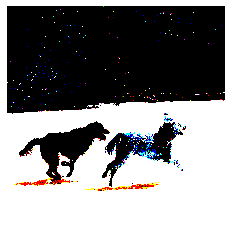

In [110]:
img = preprocess_img(IMG_PATH+"2513260012_03d33305cf.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [69]:
def encode_img(img):
    # preprocess the image
    img = preprocess_img(img)
    
    # pass image to resnet model
    feature_vector = model_new.predict(img)
    #print(feature_vector.shape)
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [178]:
print(encode_img(IMG_PATH+"1000268201_693b08cb0e.jpg"))
print(train_descriptions["1000268201_693b08cb0e"])

[0.04154292 0.17076074 0.29278558 ... 0.05089612 0.3132239  0.8600747 ]
['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq']


In [115]:
## encode all the images and save them in one file
start_time = time()
encoding_train = {}
# image_id --> feature vector extracted from resnet model

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    
    encoding_train[img_id] = encode_img(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d"%ix)
    
end_time = time()
# print("Total Time Taken :"%end_time-start_time)

Encoding in Progress Time step 0
Encoding in Progress Time step 100
Encoding in Progress Time step 200
Encoding in Progress Time step 300
Encoding in Progress Time step 400
Encoding in Progress Time step 500
Encoding in Progress Time step 600
Encoding in Progress Time step 700
Encoding in Progress Time step 800
Encoding in Progress Time step 900
Encoding in Progress Time step 1000
Encoding in Progress Time step 1100
Encoding in Progress Time step 1200
Encoding in Progress Time step 1300
Encoding in Progress Time step 1400
Encoding in Progress Time step 1500
Encoding in Progress Time step 1600
Encoding in Progress Time step 1700
Encoding in Progress Time step 1800
Encoding in Progress Time step 1900
Encoding in Progress Time step 2000
Encoding in Progress Time step 2100
Encoding in Progress Time step 2200
Encoding in Progress Time step 2300
Encoding in Progress Time step 2400
Encoding in Progress Time step 2500
Encoding in Progress Time step 2600
Encoding in Progress Time step 2700
Enco

In [116]:
print("Total Time Taken : ",end_time-start_time)

Total Time Taken :  1625.7342019081116


In [117]:
# store everything to the disk using pickle 
# pickles allows us to save data from ram to disk and load data from disk to ram

with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)



In [194]:
## encode all the test images and save them in one file
start_time = time()
encoding_test = {}
# image_id --> feature vector extracted from resnet model

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_img(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d"%ix)
    
end_time = time()
print("Total Time Taken(test) : ",end_time-start_time)

Encoding in Progress Time step 0
Encoding in Progress Time step 100
Encoding in Progress Time step 200
Encoding in Progress Time step 300
Encoding in Progress Time step 400
Encoding in Progress Time step 500
Encoding in Progress Time step 600
Encoding in Progress Time step 700
Encoding in Progress Time step 800
Encoding in Progress Time step 900
Total Time Taken(test) :  255.445720911026


In [195]:
with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)



## Step 2 : Pre-processing for Captions

In [32]:
# vocab
len(total_words)

1845

In [33]:
# create dict of vocab
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    # we are not using 0 index as we will keep it for padding
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word
    
print(len(word_to_idx))
print(len(idx_to_word))

1845
1845


In [34]:
idx_to_word[4]

'is'

In [35]:
word_to_idx["is"]

4

In [36]:
## add two special word (startseq,endseq)
word_to_idx["startseq"] = 1846
idx_to_word[1846] = "startseq"

word_to_idx["endseq"] = 1847
idx_to_word[1847] = "endseq"

In [37]:
vocab_size = len(word_to_idx) + 1
print("Vocab Size ", vocab_size)

Vocab Size  1848


In [38]:
# finding max length of caption in complete dataset
max_len = 0

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))

print(max_len)

35


In [40]:
with open("./storage/word_to_idx.pkl","wb") as w2i:
    pickle.dump(word_to_idx,w2i)

with open("./storage/idx_to_word.pkl","wb") as i2w:
    pickle.dump(idx_to_word,i2w)
    

## Data Generator

In [179]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2,y = [],[],[]
    
    n = 0
    
    while True:
        # for each image we iterate over all its captions
        # then slice each caption from 0 to i
        # for example startseq will predict dog
        # for example startseq dog will predict is
        
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    # 0 denotes padding word
                    # padding post means that we pad when sentence is finished
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                
                if n==batch_size:
                    yield[[np.array(X1),np.array(X2)],np.array(y)]
                    # when control comes back to generator function
                    # we start collection data for new batch
                    X1,X2,y = [],[],[]
                    n=0

    

## Word Embedding

In [180]:
# using glove embedding
import numpy as np
f = open("./glove.6B.50d.txt")

embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    embedding_word = np.array(values[1:],dtype='float')
    embedding_index[word] = embedding_word

In [181]:
f.close()

In [182]:
embedding_index["apple"]

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [183]:
## we dont need all the words ... we just need word present in vocab

def get_embedding_matrix():
    emb_dim = 50
    
    matrix = np.zeros((vocab_size,emb_dim))
    
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        # if a word is not present in glove then it is given value of all zeros
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    
    return matrix

In [184]:
embedding_matrix = get_embedding_matrix()
print(embedding_matrix.shape)

(1848, 50)


In [185]:
# startseq & endseq is not present in glove embedding
embedding_matrix[1847]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Model Architecture

In [186]:
# converting feature vector of image into smaller vector

# reducing size from 2048 to 256
input_img_features = Input(shape=(2048,))
input_img_1 = Dropout(0.3)(input_img_features)
input_img_2 = Dense(256,activation='relu')(input_img_1)



In [187]:
# captions as input

input_cap = Input(shape=(max_len,))
input_cap_1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_cap)
input_cap_2 = Dropout(0.3)(input_cap_1)
input_cap_3 = LSTM(256)(input_cap_2)

  

In [188]:
# add both inputs and decode them

decoder1 = add([input_img_2,input_cap_3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

In [189]:
# combined model 

model = Model(inputs=[input_img_features,input_cap],outputs=outputs)

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 35)           0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 35, 50)       92400       input_10[0][0]                   
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 2048)         0           input_9[0][0]                    
____________________________________________________________________________________________

In [190]:
## Important Thing - Pre initialize the embedding layer

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [191]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

## Training of model

In [197]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size
print(steps)

2000.0


In [193]:
for i in range(epochs):
    generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    model.save('./Model_weights/model_'+str(i)+'.h5')

Epoch 1/1
2000/2000 [==============================] - 835s 418ms/step - loss: 4.2980
Epoch 1/1
2000/2000 [==============================] - 884s 442ms/step - loss: 3.5857
Epoch 1/1
2000/2000 [==============================] - 867s 434ms/step - loss: 3.3222
Epoch 1/1
2000/2000 [==============================] - 874s 437ms/step - loss: 3.1633
Epoch 1/1
2000/2000 [==============================] - 860s 430ms/step - loss: 3.0508
Epoch 1/1
2000/2000 [==============================] - 872s 436ms/step - loss: 2.9647
Epoch 1/1
2000/2000 [==============================] - 892s 446ms/step - loss: 2.8974
Epoch 1/1
2000/2000 [==============================] - 832s 416ms/step - loss: 2.8389
Epoch 1/1
2000/2000 [==============================] - 1083s 541ms/step - loss: 2.7940
Epoch 1/1
2000/2000 [==============================] - 1018s 509ms/step - loss: 2.7545
Epoch 1/1
2000/2000 [==============================] - 887s 444ms/step - loss: 2.7203
Epoch 1/1
2000/2000 [==============================]

In [207]:
# lets load weights after 10th epoch
model = load_model('./Model_weights/model_19.h5')

## Prediction

In [208]:
def predict_caption(photo):
    
    input_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in input_text.split() if w in word_to_idx ]
        # add padding
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        y_pred = model.predict([photo,sequence])
        y_pred = y_pred.argmax() # word with max sampling - Greedy sampling
        word = idx_to_word[y_pred]
        input_text += ' ' + word
        
        if word == 'endseq':
            break
    
    final_caption = input_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

two men in red and one in black hold hands


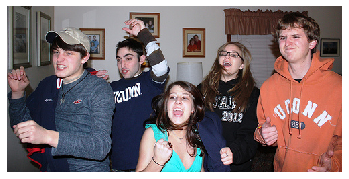

man wearing black shirt and black cap talking to the right


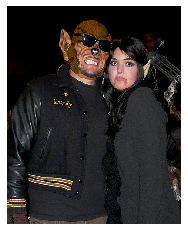

two men are sitting on bench overlooking the water


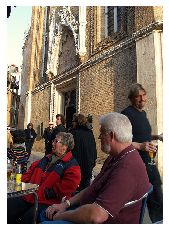

little girl in blue shirt is running on the beach


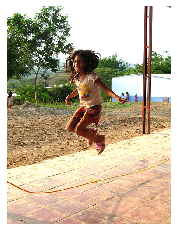

young girl in white shirt is walking on the beach


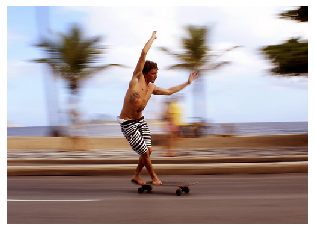

dog is running through the snow


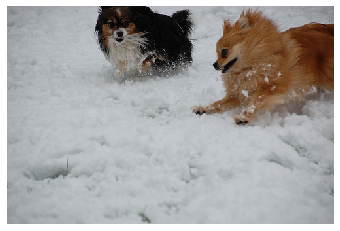

man sits on bench in front of brick wall


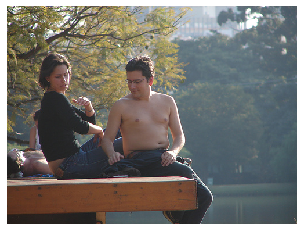

skateboarder is doing trick on ramp


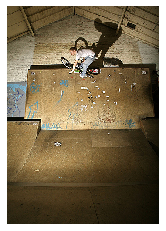

dog jumps over branch


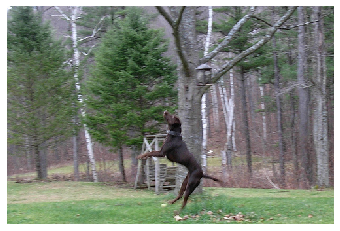

snowboarder is leaping in the air on snowy mountain


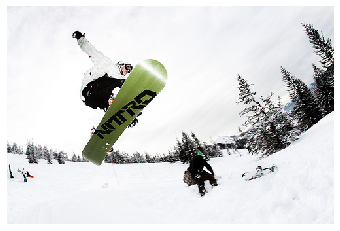

woman with tattoo wears and jean jean jean denim


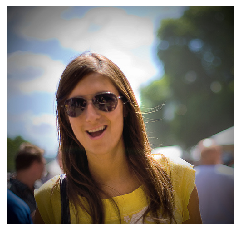

woman in black dress is standing in front of brick wall


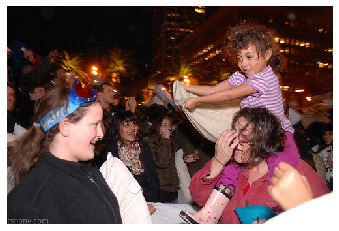

man is standing on hill in field


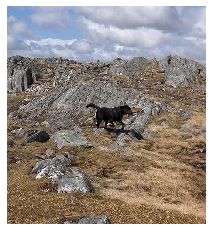

two people are riding bicycles across the snow


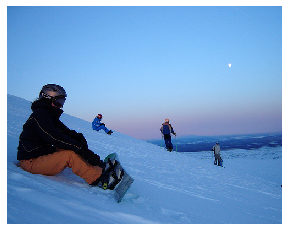

black and white dog is running through field


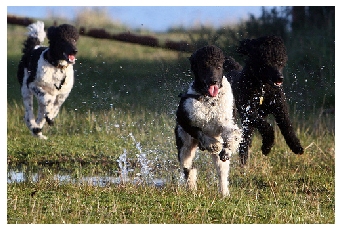

In [209]:
## pic some random images
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    caption = predict_caption(photo_2048)
    print(caption)
    
    im = plt.imread(IMG_PATH+img_name+".jpg")
    plt.axis("off")
    plt.imshow(im)
    plt.show()
    
    